In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices
import nibabel as nib


# Import shared utilities and configuration
# need to do it this way because in a sub-directory (later turn config and utils into part of a package)
from utils import (
    TASKS, CONTRASTS, SUBJECTS, SESSIONS, ENCOUNTERS,
    build_first_level_contrast_map_path, is_valid_contrast_map, clean_z_map_data,
    convert_to_regular_dict, create_smor_atlas,load_smor_atlas, load_schaefer_atlas, cleanup_memory
)
from config import BASE_DIR, OUTPUT_DIRS

In [2]:
# compile all requested contrasts into one list
compiled_req_contrasts = []
for task in TASKS:
    for contrast in CONTRASTS[task]:
        if (contrast not in compiled_req_contrasts):
            compiled_req_contrasts.append(contrast)

In [3]:
# smorgasbord stuff
SMORG_PARCELLATED_DIR = OUTPUT_DIRS["smor"]
smor_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
smor_date_updated = '1208'
indices = [1,2,3]
# get smorgasbord atlas
smorgasbord_atlas = load_smor_atlas()
SMORG_IMG = smorgasbord_atlas.maps
SMORG_DATA = SMORG_IMG.get_fdata()

Loading Smorgasbord atlas...
Atlas loaded with 429 regions
Atlas shape: (193, 229, 193)


In [4]:
req_atlas = "smor"
main_dir = SMORG_PARCELLATED_DIR
main_files = smor_files
date_updated = smor_date_updated
atlas_obj = smorgasbord_atlas
atlas_img = SMORG_IMG
atlas_data = SMORG_DATA

In [5]:
file_type = "z"
output_ending = ""
if (file_type == "z"):
    output_ending = "_z_scored"

**load the averaged parcellated indiv contrasts and fixed maps**

In [6]:
avg_parcel_traj_results = {}
mean_filename = f"{main_dir}/{main_files['mean']}_{date_updated}{output_ending}_averaged.pkl"

with open(mean_filename, 'rb') as f:
    avg_parcel_traj_results = pickle.load(f)

In [7]:
fixed_avg_parcel_traj_results = {}
fixed_filename = f"{main_dir}_fixed/discovery_parcel_fixedeffects_mean_updated_{date_updated}{output_ending}_averaged.pkl"

with open(fixed_filename, 'rb') as f:
    fixed_avg_parcel_traj_results = pickle.load(f)

# restructure the avg fixed effects parcel df to be the same structure as the averaged parcel trajectories df:
for task in fixed_avg_parcel_traj_results.keys():
    for contrast in fixed_avg_parcel_traj_results[task].keys():
        df = fixed_avg_parcel_traj_results[task][contrast]
        
        fixed_avg_parcel_traj_results[task][contrast] = {
            row['region']: {
                'activation': row['activation'],
                'network': row['network'],
                'roi_value': row['roi_value']
            }
            for _, row in df.iterrows()
        }

In [17]:
# Collate the data for the scatterplot
avg_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for task in avg_parcel_traj_results.keys():
    for contrast in avg_parcel_traj_results[task].keys():
        for parcel in avg_parcel_traj_results[task][contrast].keys():
            avg_activations[task][contrast]["parcel_names"].append(parcel)
            avg_activations[task][contrast]["avg_initial_activation"].append(avg_parcel_traj_results[task][contrast][parcel]["initial_activation_mean"])
            avg_activations[task][contrast]["avg_slope"].append(avg_parcel_traj_results[task][contrast][parcel]["slope_mean"])
            avg_activations[task][contrast]["avg_fixed_effects_val"].append(fixed_avg_parcel_traj_results[task][contrast][parcel]["activation"])

**TODO: load the individual parcellated contrast data and the individual parcellated fixed effects maps**

**functions for plotting**

In [41]:
def plot_slopes_and_fixed_effects_single_slice(avg_results, averaged_fixed_maps, task, contrast, 
                                                x_slice=0, y_slice=0, z_slice=0,
                                                n_rois=400, atlas_name=req_atlas, atlas=atlas_obj, 
                                                atlas_img=atlas_img, atlas_data=atlas_data, 
                                                threshold=None):
    """
    Create two separate brain plots (slopes and fixed effects) with specific xyz slices.
    Returns two matplotlib figure objects that can be added to another figure.
    """
    # Get atlas labels
    atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                   for label in atlas.labels]
    
    # Get slope data
    parcel_data = avg_results[task][contrast]
    
    # Get fixed effects data (it's a dict of dicts)
    fixed_effects_dict = averaged_fixed_maps[task][contrast]
    
    # Create brain image with slope values
    slope_data = np.zeros_like(atlas_data)
    
    # Create brain image with fixed effects values
    fixed_effects_data = np.zeros_like(atlas_data)
    
    # Map parcel names to atlas regions for both slopes and fixed effects
    for i, atlas_label in enumerate(atlas_labels):
        if atlas_label in parcel_data:
            slope_value = parcel_data[atlas_label]['slope_mean']
            
            # Access fixed effects from nested dictionary
            if atlas_label in fixed_effects_dict:
                fixed_effect_value = fixed_effects_dict[atlas_label]['activation']
            else:
                fixed_effect_value = 0  # Default value if not found
            
            if hasattr(atlas, 'roi_values'):
                roi_value = atlas.roi_values[i]
                slope_data[atlas_data == roi_value] = slope_value
                fixed_effects_data[atlas_data == roi_value] = fixed_effect_value
            else:
                slope_data[atlas_data == (i + 1)] = slope_value
                fixed_effects_data[atlas_data == (i + 1)] = fixed_effect_value

    # Create NIfTI images for slopes and fixed effects
    slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
    fixed_effects_img = nib.Nifti1Image(fixed_effects_data, atlas_img.affine)

    # Calculate vmin and vmax for slopes
    nonzero_slopes = slope_data[slope_data != 0]
    vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
    abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
    vmin_slope, vmax_slope = -abs_max_slope, abs_max_slope

    # Calculate vmin and vmax for fixed effects
    nonzero_fe = fixed_effects_data[fixed_effects_data != 0]
    vmin_fe, vmax_fe = np.percentile(nonzero_fe, [2, 98])
    abs_max_fe = max(abs(vmin_fe), abs(vmax_fe))

    # Create slopes plot
    plt.figure()
    display_slopes = plotting.plot_stat_map(slope_img,
                           colorbar=True,
                           cmap='RdBu_r',
                           vmin=vmin_slope,
                           vmax=vmax_slope,
                           threshold=threshold,
                           display_mode='z',
                           cut_coords=[z_slice],
                           draw_cross=True,
                           title=f'Slopes: {task}/{contrast}')
    
    
    # Create fixed effects plot
    plt.figure()
    display_fe = plotting.plot_stat_map(fixed_effects_img,
                           colorbar=True,
                           cmap='RdBu_r',
                           vmin=-abs_max_fe,
                           vmax=abs_max_fe,
                           symmetric_cbar=True,
                           threshold=threshold,
                           display_mode='z',
                           cut_coords=[z_slice],
                           draw_cross=True,
                           title=f'Fixed Effects: {task}/{contrast}')
    
    plt.show()
    
    return display_slopes, display_fe

<Figure size 640x480 with 0 Axes>

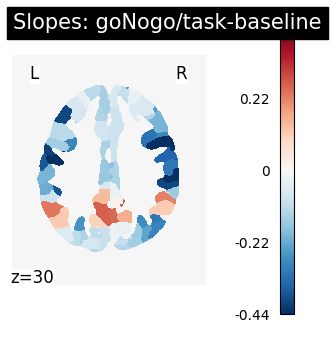

<Figure size 640x480 with 0 Axes>

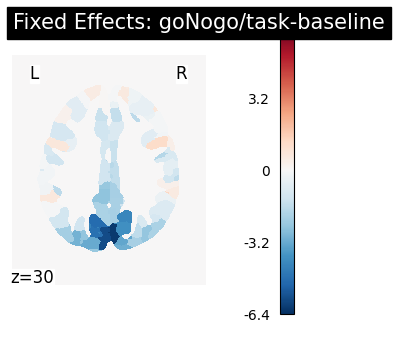

In [42]:
fig_slopes, fig_fe = plot_slopes_and_fixed_effects_single_slice(
    avg_parcel_traj_results, 
    fixed_avg_parcel_traj_results, 
    task='goNogo', 
    contrast='task-baseline',
    x_slice=10,
    y_slice=20,
    z_slice=30
)

In [46]:
# Calculate global limits across ALL tasks and contrasts (excluding response_time)
all_x_vals = []
all_y_vals = []

for task in avg_activations.keys():
    for contrast in avg_activations[task].keys():
        if contrast == "response_time":
            continue
            
        x_vals = avg_activations[task][contrast]["avg_fixed_effects_val"]
        y_vals = avg_activations[task][contrast]["avg_slope"]
        
        # Check if arrays are not empty
        if len(x_vals) > 0 and len(y_vals) > 0:
            all_x_vals.extend(x_vals)
            all_y_vals.extend(y_vals)
        else:
            print(f"Warning: Empty data for {task} - {contrast}")

# Check if we have any data
if len(all_x_vals) == 0 or len(all_y_vals) == 0:
    raise ValueError("No valid data found across tasks and contrasts")

# Calculate limits
x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(f"X-axis limits (Fixed Effects): [{x_min:.3f}, {x_max:.3f}]")
print(f"Y-axis limits (Slopes): [{y_min:.3f}, {y_max:.3f}]")
print(f"Number of data points: {len(all_x_vals)}")

X-axis limits (Fixed Effects): [-12.937, 8.423]
Y-axis limits (Slopes): [-0.613, 0.630]
Number of data points: 15015


In [47]:
# function which returns the scatterplot of slope vs fixed effects
def get_network_category(parcel_name):
    if 'Vis' in parcel_name:
        return 'Visual'
    elif 'SomMot' in parcel_name:
        return 'Somatomotor'
    elif 'DorsAttn' in parcel_name:
        return 'Dorsal Attention'
    elif 'SalVentAttn' in parcel_name:
        return 'Salience/Ventral Attention'
    elif 'Limbic' in parcel_name:
        return 'Limbic'
    elif 'Cont' in parcel_name:
        return 'Control'
    elif 'Default' in parcel_name:
        return 'Default Mode'
    else:
        return 'Subcortical/Other'

# Create color mapping
network_colors = {
    'Visual': 'blue',
    'Somatomotor': 'green',
    'Dorsal Attention': 'orange',
    'Salience/Ventral Attention': 'purple',
    'Limbic': 'pink',
    'Control': 'red',
    'Default Mode': 'yellow',
    'Subcortical/Other': 'gray'
}

def scatterplot_fe_slope(activations_dict, task, contrast, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max):
    """
    Create scatterplot of slope vs fixed effects for a single task/contrast.
    Returns the figure object.
    """
    n_contrasts = 1
    n_rows, n_cols = 1, 1
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Get parcel names and network categories
    parcels = activations_dict[task][contrast]["parcel_names"]
    network_categories = [get_network_category(p) for p in parcels]
    
    # Get x and y values
    x_all = activations_dict[task][contrast]["avg_fixed_effects_val"]
    y_all = activations_dict[task][contrast]["avg_slope"]
    
    # Plot each network separately for legend
    for network in network_colors.keys():
        mask = [cat == network for cat in network_categories]
        if any(mask):
            x_vals = [x_all[i] for i, m in enumerate(mask) if m]
            y_vals = [y_all[i] for i, m in enumerate(mask) if m]
            
            ax.scatter(x_vals, y_vals, 
                      c=network_colors[network], 
                      label=network, 
                      alpha=0.6, 
                      s=30)
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title(f"{task} | {contrast}\nScatterplot of average slope change by average fixed effects value")
    ax.set_xlabel("Average Fixed Effects Value (zstats)")
    ax.set_ylabel("Average slope of linear model fit to parcel")
    ax.legend(fontsize=8, loc='best')
    
    # Set axis limits
    if contrast != "response_time":
        if x_min is not None and x_max is not None:
            ax.set_xlim(x_min, x_max)
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)
    else: 
        # For response_time, calculate dynamic limits
        if x_min is not None and x_max is not None:
            rt_max_x = max(x_max, np.max(x_all))
            rt_min_x = min(x_min, np.min(x_all))
        else:
            rt_max_x = np.max(x_all)
            rt_min_x = np.min(x_all)
            
        if y_min is not None and y_max is not None:
            rt_max_y = max(y_max, np.max(y_all))
            rt_min_y = min(y_min, np.min(y_all))
        else:
            rt_max_y = np.max(y_all)
            rt_min_y = np.min(y_all)
            
        ax.set_xlim(rt_min_x, rt_max_x)
        ax.set_ylim(rt_min_y, rt_max_y)
    
    plt.tight_layout()
    
    return fig

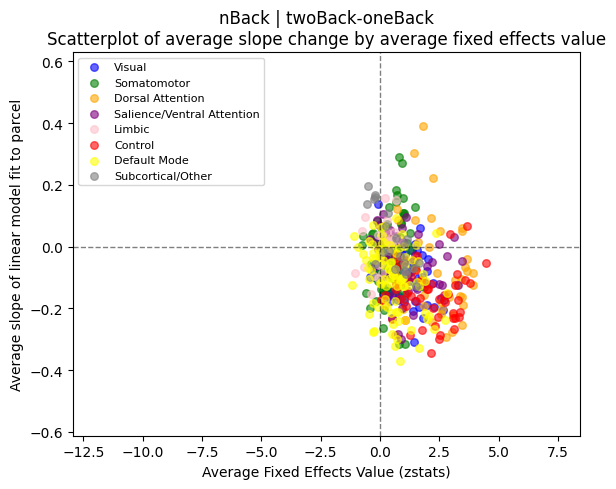

In [48]:
fig = scatterplot_fe_slope(avg_activations, 'nBack', 'twoBack-oneBack')
plt.show()

**create the plot for the averaged results**

In [78]:
def plot_comprehensive_summary(avg_activations, avg_parcel_traj_results, fixed_avg_parcel_traj_results,
                                tasks_to_plot, z_slice=0,
                                x_min=None, x_max=None, y_min=None, y_max=None,
                                threshold=None, save_path="OHBM_plot.png"):
    """
    Create a 8x3 plot showing fixed effects, slopes, and scatterplot for each task/contrast.
    
    Parameters:
    -----------
    avg_activations : dict
        Dictionary containing activation data for scatterplots
    avg_parcel_traj_results : dict
        Dictionary containing slope results
    fixed_avg_parcel_traj_results : dict
        Dictionary containing fixed effects results
    tasks_to_plot : dict
        Dictionary mapping task names to contrasts
    z_slice : int
        Brain slice coordinate for axial view
    x_min, x_max, y_min, y_max : float
        Axis limits for scatterplots
    threshold : float
        Threshold for brain maps
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig : matplotlib figure
    """
    n_tasks = len(tasks_to_plot)
    fig = plt.figure(figsize=(18, 5*n_tasks))  # 3 columns, n_tasks rows
    
    # Create a grid: n_tasks rows x 3 columns (fixed effects, slopes, scatterplot)
    # Add more top margin to make room for title and headers
    gs = fig.add_gridspec(n_tasks, 3, hspace=0.4, wspace=0.3, top=0.91, bottom=0.02, left=0.05, right=0.95)
    
    task_names = list(tasks_to_plot.keys())
    
    for row_idx, task in enumerate(task_names):
        contrast = tasks_to_plot[task]
        
        print(f"Processing {task} - {contrast}...")
        
        # Get atlas labels (needed for both brain maps)
        atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                       for label in atlas_obj.labels]
        
        # Column 0: Fixed effects brain map
        fixed_effects_dict = fixed_avg_parcel_traj_results[task][contrast]
        fixed_effects_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in fixed_effects_dict:
                fixed_effect_value = fixed_effects_dict[atlas_label]['activation']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    fixed_effects_data[atlas_data == roi_value] = fixed_effect_value
                else:
                    fixed_effects_data[atlas_data == (i + 1)] = fixed_effect_value
        
        fixed_effects_img = nib.Nifti1Image(fixed_effects_data, atlas_img.affine)
        nonzero_fe = fixed_effects_data[fixed_effects_data != 0]
        vmin_fe, vmax_fe = np.percentile(nonzero_fe, [2, 98])
        abs_max_fe = max(abs(vmin_fe), abs(vmax_fe))
        
        ax_fe = fig.add_subplot(gs[row_idx, 0])
        plotting.plot_stat_map(fixed_effects_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_fe,
                               vmax=abs_max_fe,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_fe,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 1: Slopes brain map
        parcel_data = avg_parcel_traj_results[task][contrast]
        slope_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in parcel_data:
                slope_value = parcel_data[atlas_label]['slope_mean']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    slope_data[atlas_data == roi_value] = slope_value
                else:
                    slope_data[atlas_data == (i + 1)] = slope_value
        
        slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
        nonzero_slopes = slope_data[slope_data != 0]
        vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
        abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
        
        ax_slopes = fig.add_subplot(gs[row_idx, 1])
        plotting.plot_stat_map(slope_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_slope,
                               vmax=abs_max_slope,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_slopes,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 2: Scatterplot
        ax_scatter = fig.add_subplot(gs[row_idx, 2])
        
        # Get parcel names and network categories
        parcels = avg_activations[task][contrast]["parcel_names"]
        network_categories = [get_network_category(p) for p in parcels]
        
        # Get x and y values
        x_all = avg_activations[task][contrast]["avg_fixed_effects_val"]
        y_all = avg_activations[task][contrast]["avg_slope"]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [x_all[i] for i, m in enumerate(mask) if m]
                y_vals = [y_all[i] for i, m in enumerate(mask) if m]
                
                ax_scatter.scatter(x_vals, y_vals, 
                          c=network_colors[network], 
                          label=network, 
                          alpha=0.6, 
                          s=20)
        
        ax_scatter.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.set_xlabel("Avg Fixed Effects (z)", fontsize=10)
        ax_scatter.set_ylabel("Avg Slope", fontsize=10)
        
        # Only show legend for first plot
        if row_idx == 0:
            ax_scatter.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))
        
        # Set axis limits
        if contrast != "response_time" and x_min is not None:
            ax_scatter.set_xlim(x_min, x_max)
            ax_scatter.set_ylim(y_min, y_max)
        
        # Add task/contrast label - anchored to the middle subplot position
        # Get the position of the middle subplot (slopes)
        bbox = ax_slopes.get_position()
        label_y = bbox.y1 + 0.01  # Slightly above the top of the subplot
        
        fig.text(0.5, label_y, f"{task} | {contrast}", 
                ha='center', va='bottom', fontsize=12, fontweight='bold',
                transform=fig.transFigure)
    
    # Add main title at the very top
    fig.suptitle(f'Changes across time in 8 task/contrast pairs (z={z_slice})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Add column headers - between title and plots
    fig.text(0.22, 0.94, 'Averaged Fixed Effects (zstats)', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.53, 0.94, 'Averaged Slopes of Change', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.84, 0.94, 'Scatterplot', ha='center', fontsize=13, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig

Processing cuedTS - cue_switch_cost...
Processing directedForgetting - neg-con...
Processing flanker - incongruent-congruent...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing shapeMatching - main_vars...
Processing spatialTS - cue_switch_cost...
Processing stopSignal - stop_failure-stop_success...
Figure saved to OHBM_plot.png


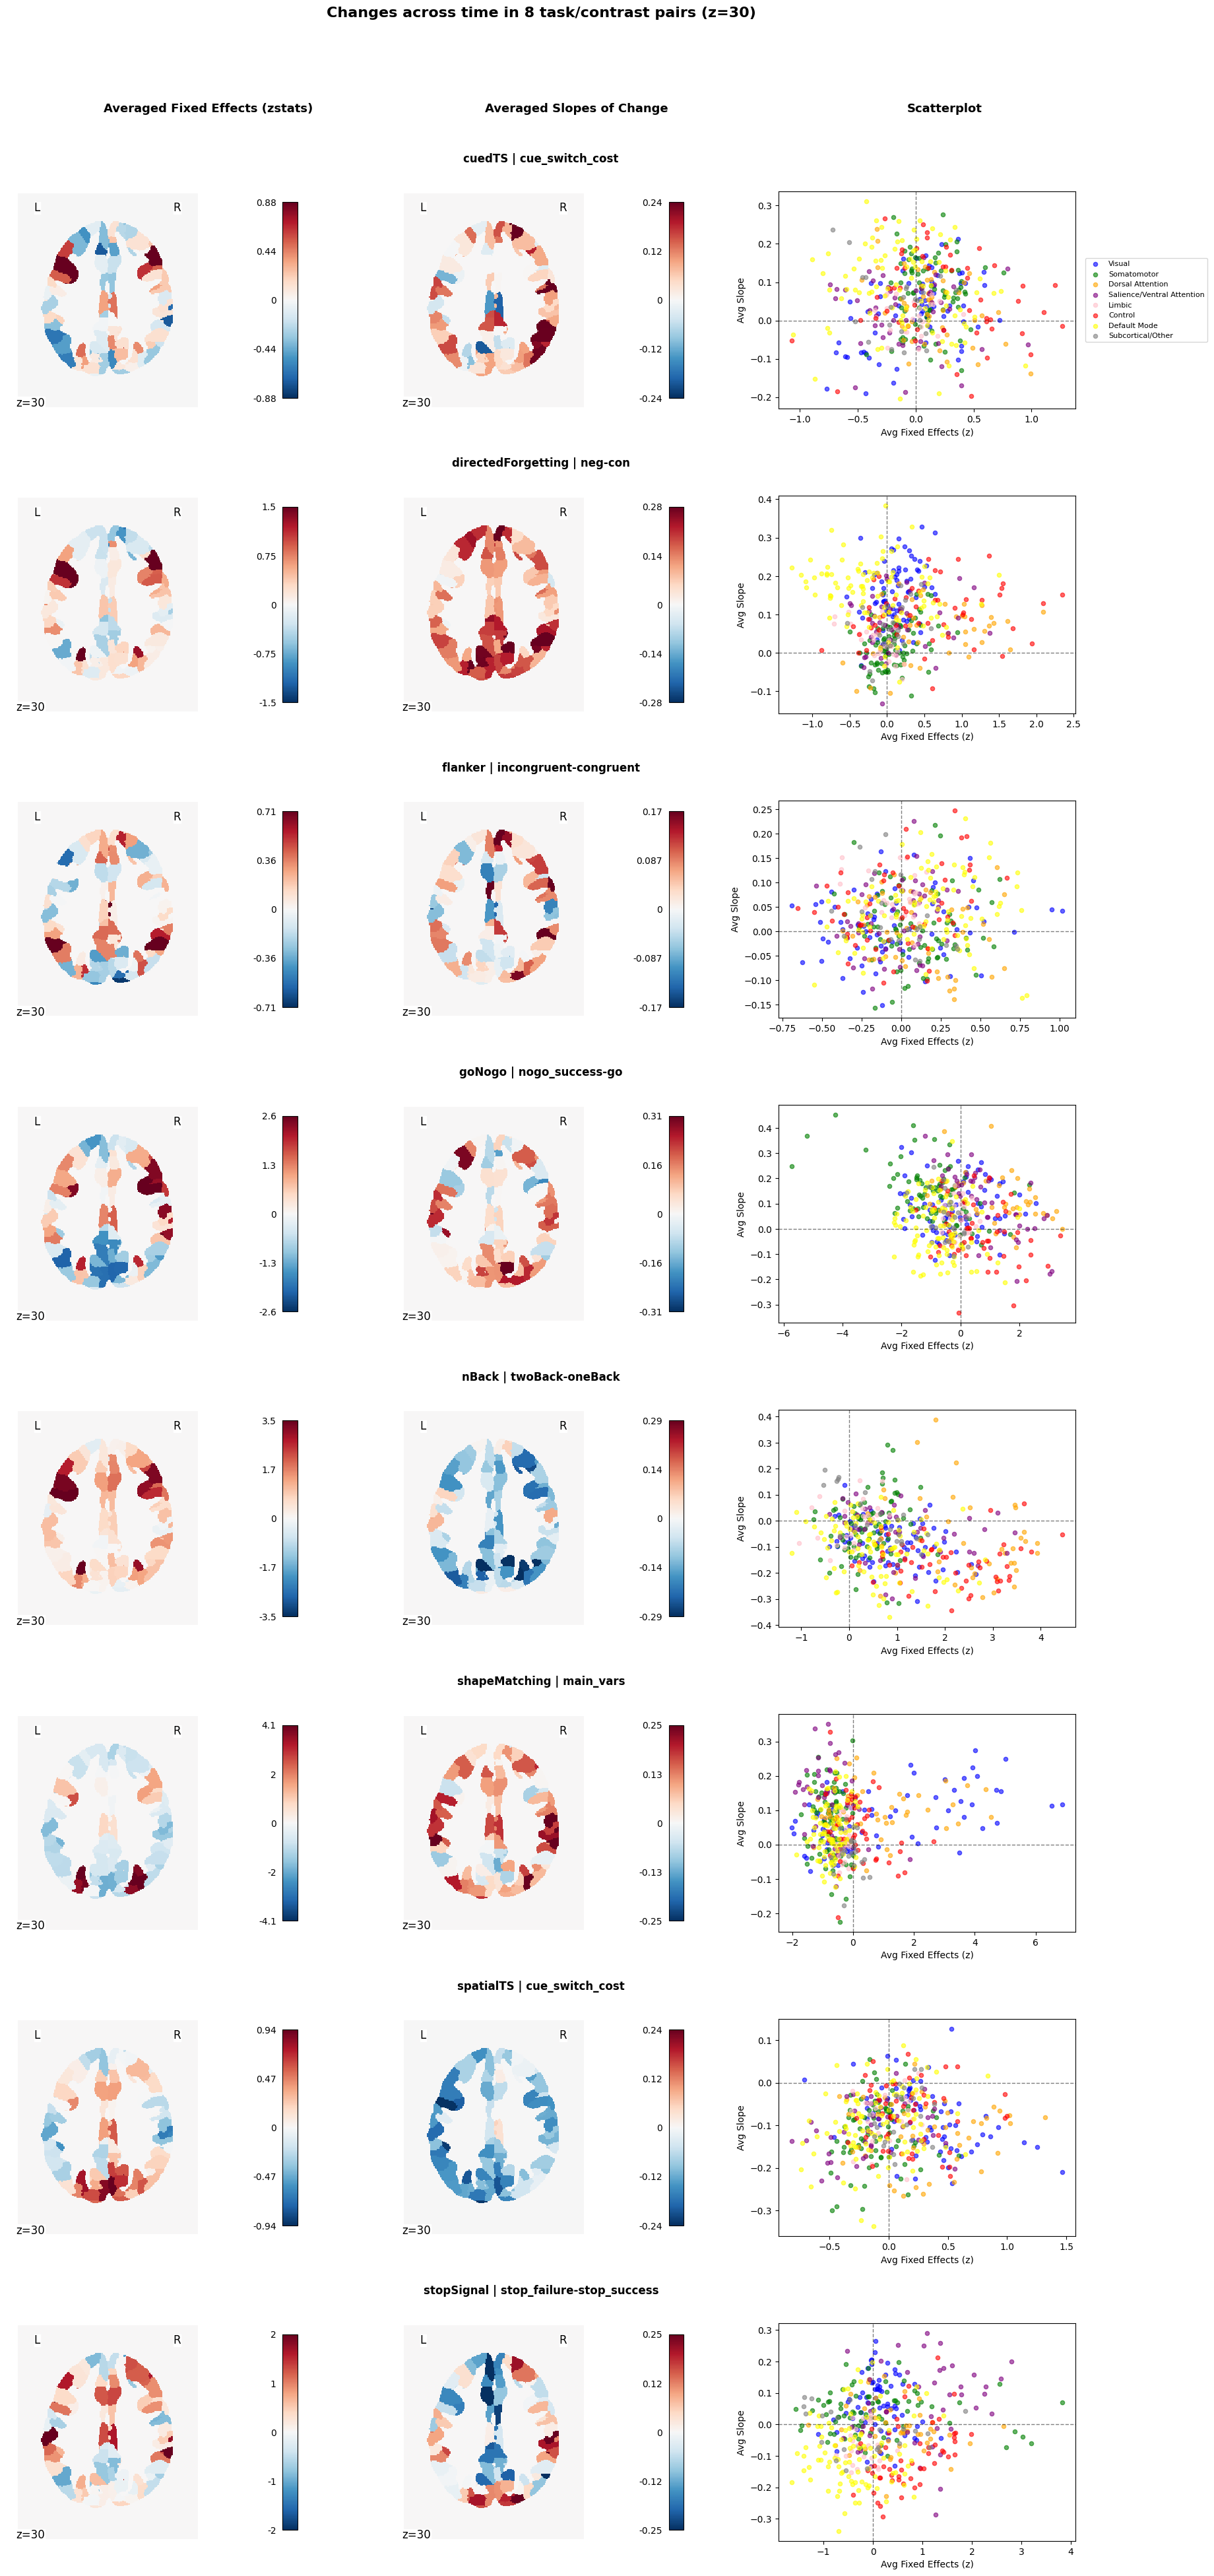

In [79]:
tasks_to_plot = {
    "cuedTS":"cue_switch_cost",
    "directedForgetting":"neg-con",
    "flanker":"incongruent-congruent",
    "goNogo": "nogo_success-go",
    "nBack": "twoBack-oneBack",
    "shapeMatching": "main_vars",
    "spatialTS": "cue_switch_cost",
    "stopSignal": "stop_failure-stop_success"
}
# tasks_to_plot = {
#     "cuedTS":"cue_switch_cost"
# }

fig = plot_comprehensive_summary(
    avg_activations,
    avg_parcel_traj_results,
    fixed_avg_parcel_traj_results,
    tasks_to_plot,
    z_slice=30
)

plt.show()